<center><h1>PyTorch Introduction with Feed-forward Neural Network</h1></center>


- https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
- https://pytorch.org/tutorials/beginner/deep_learning_nlp_tutorial.html 


1. load example 
1. introduce tensor operations 
2. NN intro : https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html#sphx-glr-beginner-nlp-deep-learning-tutorial-py 
2. introduce how to build model structure --> dynamic graphs & auto-differentiation
4. introduce data loader 


hands on steps:
1. clone repo, create venv & install dependencies
2. practice 

## create example dataset

In [4]:
import torch
from torch import FloatTensor
from torch.autograd import Variable

# from IPython.display import Image
# Image("img/picture.png")

In [20]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

## 1. Tensors

![Tensors](images/tensors.jpg)

#### sample from uniform distribution

In [8]:
## sample from uniform distribution on interval [0,1)
a = torch.rand([3, 2, 4], dtype=torch.float)
print(a.size())
a

torch.Size([3, 2, 4])


tensor([[[9.3290e-01, 1.8002e-01, 7.6481e-01, 7.8839e-01],
         [2.2025e-02, 1.8197e-01, 3.3011e-02, 1.4004e-01]],

        [[7.0514e-01, 2.8230e-01, 8.3122e-01, 2.1743e-01],
         [2.8923e-02, 7.9992e-01, 7.5044e-01, 6.9387e-01]],

        [[3.6114e-01, 2.1788e-01, 9.9166e-01, 2.9854e-02],
         [5.6667e-01, 9.9337e-01, 6.9594e-04, 7.8854e-01]]])

(array([1025.,  965., 1036.,  975., 1007., 1011.,  980., 1081.,  974.,
         946.]),
 array([2.0182133e-04, 1.0017974e-01, 2.0015766e-01, 3.0013558e-01,
        4.0011349e-01, 5.0009143e-01, 6.0006934e-01, 7.0004725e-01,
        8.0002517e-01, 9.0000308e-01, 9.9998099e-01], dtype=float32),
 <a list of 10 Patch objects>)

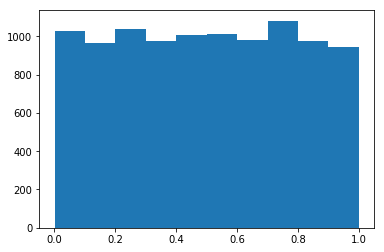

In [24]:
plt.hist(torch.rand(10000, dtype=torch.float))

#### sample from standard normal distribution
$$X \sim \mathcal{N}(\mu,\,\sigma^{2})$$
$$\mu = 0, \sigma^2 = 1$$

In [9]:
b = torch.randn([3, 2, 4], dtype=torch.float)
print(b.size())
b

torch.Size([3, 2, 4])


tensor([[[-0.7470,  1.0582,  0.1937, -0.0603],
         [ 0.3241,  1.3472, -0.9389,  0.3450]],

        [[-0.4761, -1.2414,  0.4378,  1.4032],
         [-0.0529, -0.2141,  0.7765, -1.5441]],

        [[-1.6407, -0.4038, -1.0024,  1.2693],
         [ 0.2396, -0.9658, -2.2389, -0.8972]]])

(array([  1.,   1.,   3.,   3.,   8.,   8.,  23.,  27.,  42.,  86., 109.,
        212., 225., 345., 429., 508., 635., 695., 791., 774., 813., 765.,
        701., 601., 555., 439., 360., 262., 186., 136.,  98.,  69.,  34.,
         29.,   9.,  10.,   4.,   3.,   1.]),
 array([-4.01592255, -3.8159225 , -3.61592245, -3.4159224 , -3.21592236,
        -3.01592231, -2.81592226, -2.61592221, -2.41592216, -2.21592212,
        -2.01592207, -1.81592202, -1.61592197, -1.41592193, -1.21592188,
        -1.01592183, -0.81592178, -0.61592174, -0.41592169, -0.21592164,
        -0.01592159,  0.18407845,  0.3840785 ,  0.58407855,  0.7840786 ,
         0.98407865,  1.18407869,  1.38407874,  1.58407879,  1.78407884,
         1.98407888,  2.18407893,  2.38407898,  2.58407903,  2.78407907,
         2.98407912,  3.18407917,  3.38407922,  3.58407927,  3.78407931]),
 <a list of 39 Patch objects>)

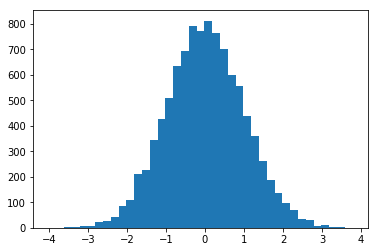

In [23]:
x = torch.randn(10000, dtype=torch.float)
binwidth = 0.2
plt.hist(
    x,
    bins=np.arange(min(x), max(x) + binwidth, binwidth),
)

In [47]:
# Ones
torch.ones([3, 2], dtype=torch.float)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

In [46]:
# Zeros
torch.zeros([3, 2], dtype=torch.long)

tensor([[0, 0],
        [0, 0],
        [0, 0]])

In [49]:
torch.empty([3, 2])

tensor(-1.5846e+29)

In [29]:
# create tensor from defined values
inputs = np.random.normal(size = 5)
torch.tensor(inputs)

tensor([-1.9711, -1.6125, -0.5584, -1.4938, -1.4421], dtype=torch.float64)

#### reshape tensor

In [43]:
print(a.view(2, 2, 2, 3))
print(a.view(2, -1))

tensor([[[[9.3290e-01, 1.8002e-01, 7.6481e-01],
          [7.8839e-01, 2.2025e-02, 1.8197e-01]],

         [[3.3011e-02, 1.4004e-01, 7.0514e-01],
          [2.8230e-01, 8.3122e-01, 2.1743e-01]]],


        [[[2.8923e-02, 7.9992e-01, 7.5044e-01],
          [6.9387e-01, 3.6114e-01, 2.1788e-01]],

         [[9.9166e-01, 2.9854e-02, 5.6667e-01],
          [9.9337e-01, 6.9594e-04, 7.8854e-01]]]])
tensor([[9.3290e-01, 1.8002e-01, 7.6481e-01, 7.8839e-01, 2.2025e-02, 1.8197e-01,
         3.3011e-02, 1.4004e-01, 7.0514e-01, 2.8230e-01, 8.3122e-01, 2.1743e-01],
        [2.8923e-02, 7.9992e-01, 7.5044e-01, 6.9387e-01, 3.6114e-01, 2.1788e-01,
         9.9166e-01, 2.9854e-02, 5.6667e-01, 9.9337e-01, 6.9594e-04, 7.8854e-01]])


## Create sample dataset

## 2. Tensor Operations

In [16]:
result = torch.empty(50,5)
torch.add(x, y, out=result)
result

tensor([[1.7017, 1.7914, 1.4914, 1.4276, 1.9476],
        [1.8033, 1.4952, 1.1866, 1.9514, 1.3953],
        [1.0239, 1.6516, 1.8082, 1.2523, 1.0159],
        [1.5697, 1.0099, 1.0467, 1.8801, 1.8705],
        [1.3822, 1.4793, 1.0240, 1.2177, 1.5196],
        [1.2991, 1.8800, 1.5323, 1.5808, 1.5694]])

In [20]:
y.add_(x)


tensor([[1.7017, 1.7914, 1.4914, 1.4276, 1.9476],
        [1.8033, 1.4952, 1.1866, 1.9514, 1.3953],
        [1.0239, 1.6516, 1.8082, 1.2523, 1.0159],
        [1.5697, 1.0099, 1.0467, 1.8801, 1.8705],
        [1.3822, 1.4793, 1.0240, 1.2177, 1.5196],
        [1.2991, 1.8800, 1.5323, 1.5808, 1.5694]])

In [33]:
x.t()

tensor([[1.7017, 1.8033, 1.0239, 1.5697],
        [1.7914, 1.4952, 1.6516, 1.0099],
        [1.4914, 1.1866, 1.8082, 1.0467]])

In [56]:
x.view(3,-1).numpy()

array([[1.7016623, 1.7914276, 1.491406 , 1.427597 , 1.9475865, 1.8033227,
        1.4951804, 1.18656  , 1.9513848, 1.3952674],
       [1.0239484, 1.6515915, 1.8081985, 1.2523246, 1.0158731, 1.5697323,
        1.00993  , 1.0466868, 1.8801205, 1.8704522],
       [1.3822478, 1.4793308, 1.0240295, 1.2177212, 1.5196092, 1.2991079,
        1.8800128, 1.5322652, 1.5808125, 1.5693561]], dtype=float32)

In [53]:
x.numpy()

array([[1.7016623, 1.7914276, 1.491406 , 1.427597 , 1.9475865],
       [1.8033227, 1.4951804, 1.18656  , 1.9513848, 1.3952674],
       [1.0239484, 1.6515915, 1.8081985, 1.2523246, 1.0158731],
       [1.5697323, 1.00993  , 1.0466868, 1.8801205, 1.8704522],
       [1.3822478, 1.4793308, 1.0240295, 1.2177212, 1.5196092],
       [1.2991079, 1.8800128, 1.5322652, 1.5808125, 1.5693561]],
      dtype=float32)

In [57]:
torch.cuda.is_available()

False

In [2]:
torch.Tensor

torch.Tensor

In [8]:
a = torch.randn(2, 2)
a.requires_grad_(True)
a = ((a * 3) / (a - 1))
# print(a.requires_grad)


In [24]:
x = torch.rand(3,5)
x.requires_grad_(True)
out = (x * x).sum()

In [27]:
out.backward()

In [28]:
print(x.grad)

tensor([[1.7054, 0.2607, 1.6669, 1.2851, 0.4250],
        [1.0825, 1.1722, 1.2196, 0.0913, 0.5207],
        [1.5642, 1.5307, 0.3049, 1.1383, 1.3529]])


In [34]:
x = torch.rand(3, requires_grad=True)

In [39]:
y = x*2

In [48]:
y.data.norm()

tensor(1.6434)

In [51]:
torch.norm(y,2)

tensor(1.6434, grad_fn=<NormBackward0>)

## Feedforward Neural Network

![Feedforward Neural Net](images/feedforward_nn_structure.png)

In [69]:
batch_size = 50
D_in = 5
h = 3
x = torch.rand(batch_size, D_in)
w1 = torch.randn(D_in, h)
affine = x.mm(w1)

In [73]:
#### 2 layer connected NN

dtype = torch.float
device = torch.device("cpu")
N, D_in, H, D_out = 64, 1000, 100, 10


x = torch.randn(N, D_in, device=device, dtype=dtype) # input
y = torch.randn(N, D_out, device=device, dtype=dtype) # output

# weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for epoch in range(5):
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    loss = (y_pred - y).pow(2).sum()
    print(epoch, loss.item())
    loss.backward()
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        w1.grad.zero_()
        w2.grad.zero_()

0 37252276.0
1 33675384.0
2 33421544.0
3 30976762.0
4 24297810.0
